In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
from torch.utils.data import Subset
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

ModuleNotFoundError: No module named 'requests'

In [2]:
#Organizing the dataset
data_dir = '/raid/ee-mariyam/maryam/ayush/PlantVillage'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

import json

# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
included_subdirs = ['Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Target_Spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Tomato_mosaic_virus']
image_datasets = {}
for x in ['train', 'val']:
    dir_path = os.path.join(data_dir, x)
    included_paths = [os.path.join(dir_path, subdir) for subdir in included_subdirs]
    dataset = datasets.ImageFolder(dir_path, transform=data_transforms[x])

    # Filter samples and update class indexing
    filtered_samples = [
        (path, class_idx)
        for path, class_idx in dataset.samples
        if os.path.dirname(path) in included_paths
    ]
    if len(filtered_samples) == 0:
        raise ValueError(f"No samples found in the included subdirectories for '{x}' split.")

    filtered_paths, filtered_targets = zip(*filtered_samples)
    unique_targets = sorted(set(filtered_targets))
    target_mapping = {class_idx: i for i, class_idx in enumerate(unique_targets)}

    filtered_targets = [target_mapping[class_idx] for class_idx in filtered_targets]
    dataset.samples = list(zip(filtered_paths, filtered_targets))
    dataset.targets = filtered_targets
    dataset.classes = [dataset.classes[class_idx] for class_idx in unique_targets]

    image_datasets[x] = dataset

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [4]:
train_loader=dataloaders['train']
test_loader=dataloaders['val']

In [7]:
!pip install timm

  Using cached timm-0.9.16-py3-none-any.whl.metadata (38 kB)
  Using cached huggingface_hub-0.21.3-py3-none-any.whl.metadata (13 kB)
  Using cached fsspec-2024.2.0-py3-none-any.whl.metadata (6.8 kB)
Using cached timm-0.9.16-py3-none-any.whl (2.2 MB)
Using cached huggingface_hub-0.21.3-py3-none-any.whl (346 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.0 MB/s eta 0:00:00a 0:00:01
Using cached fsspec-2024.2.0-py3-none-any.whl (170 kB)


In [10]:
!pip install transformers
from transformers import ConvNextConfig, ConvNextModel

# Initializing a ConvNext convnext-tiny-224 style configuration
configuration = ConvNextConfig()

# Initializing a model (with random weights) from the convnext-tiny-224 style configuration
model = ConvNextModel(configuration)

# Accessing the model configuration
configuration = model.config

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 3.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 41.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.0/777.0 kB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 74.4 MB/s eta 0:00:00a 0:00:01


In [11]:
print(model)

ConvNextModel(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=384, out_features=96, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELUAc

# GradCAM part


In [7]:
!pip install transformers[vit_interpreters]

In [8]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from timm.models import create_model
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor

def to_tensor(img):
    transform_fn = Compose([Resize(249, 3), CenterCrop(224), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    return transform_fn(img)

def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(5, 5))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward



/raid/ee-mariyam/maryam/miniconda3/envs/ayush/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import time

model = create_model('deit_small_distilled_patch16_224', pretrained=True)
model.classifier = nn.Linear(1000, 10)
num_classes = 10  # Change this according to your dataset
# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Fine-tune the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
training_start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        # logits = outputs.logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_predictions / total_predictions

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy:.2f}%")

print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

Epoch 1/10, Loss: 0.5001358803093483, Train Accuracy: 85.08%
Epoch 2/10, Loss: 0.1874551951977332, Train Accuracy: 93.84%
Epoch 3/10, Loss: 0.14910505064782317, Train Accuracy: 95.08%
Epoch 4/10, Loss: 0.1271826101240579, Train Accuracy: 95.67%
Epoch 5/10, Loss: 0.11306075326903918, Train Accuracy: 96.31%
Epoch 6/10, Loss: 0.11543208680878096, Train Accuracy: 96.21%
Epoch 7/10, Loss: 0.09869048300270851, Train Accuracy: 96.56%
Epoch 8/10, Loss: 0.09546092033851891, Train Accuracy: 96.72%
Epoch 9/10, Loss: 0.09644700260513084, Train Accuracy: 96.79%
Epoch 10/10, Loss: 0.08261415594064561, Train Accuracy: 97.12%
Training finished, took 341.32s


In [ ]:
# torch.save(model, '/raid/ee-mariyam/maryam/ayush/modelsDeiT_PlantVillageTomtato_WithoutBackground.h5')

In [23]:
class_mapping = image_datasets['train'].class_to_idx
print(class_mapping)

{'Tomato___Bacterial_spot': 0, 'Tomato___Early_blight': 1, 'Tomato___Late_blight': 2, 'Tomato___Leaf_Mold': 3, 'Tomato___Septoria_leaf_spot': 4, 'Tomato___Spider_mites Two-spotted_spider_mite': 5, 'Tomato___Target_Spot': 6, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Tomato___healthy': 9}


tensor(1, device='cuda:0')


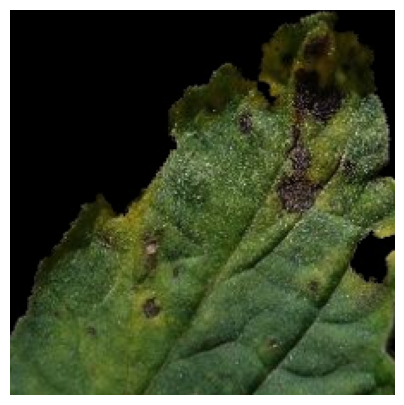

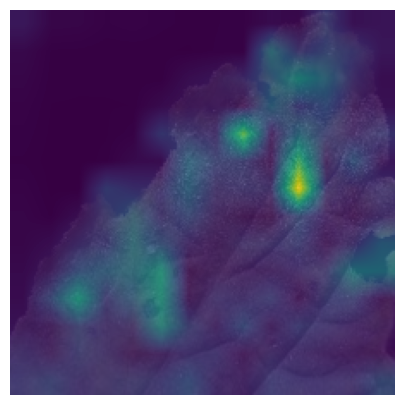

In [26]:
img = Image.open('/raid/ee-mariyam/maryam/ayush/PlantVillage_withoutbackground/train/Tomato___Early_blight/0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly.B 8389_marked.JPG')
x = to_tensor(img).to(device)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)
y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
softmax = torch.nn.Softmax(dim=1)
probs = softmax(y)
predicted_class = torch.argmax(probs)
print(predicted_class)

# show_img(img)
# show_img(attn_map)
# show_img(cls_weight)
show_img(img_resized.cpu())
show_img2(img_resized.cpu(), cls_resized.cpu(), alpha=0.8)

tensor(5, device='cuda:0')


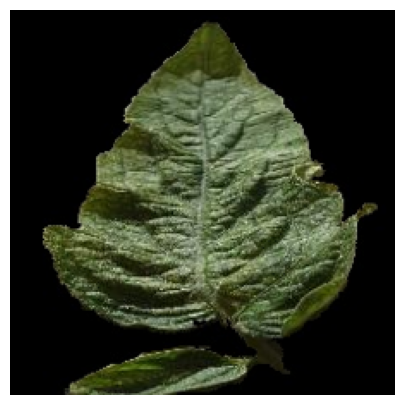

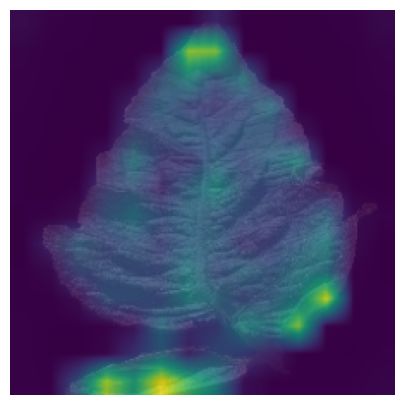

In [27]:
img = Image.open('/raid/ee-mariyam/maryam/ayush/PlantVillage_withoutbackground/val/Tomato___Spider_mites Two-spotted_spider_mite/fdd972d8-a61e-4ae6-b2ae-08c2e3db0900___Com.G_SpM_FL 8856_marked.JPG')
x = to_tensor(img).to(device)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)
y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
softmax = torch.nn.Softmax(dim=1)
probs = softmax(y)
predicted_class = torch.argmax(probs)
print(predicted_class)
# show_img(img)
# show_img(attn_map)
# show_img(cls_weight)
show_img(img_resized.cpu())
show_img2(img_resized.cpu(), cls_resized.cpu(), alpha=0.8)

tensor(2, device='cuda:0')


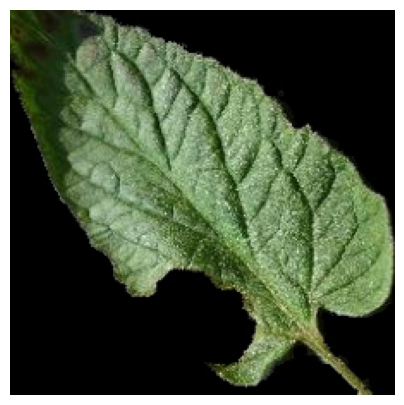

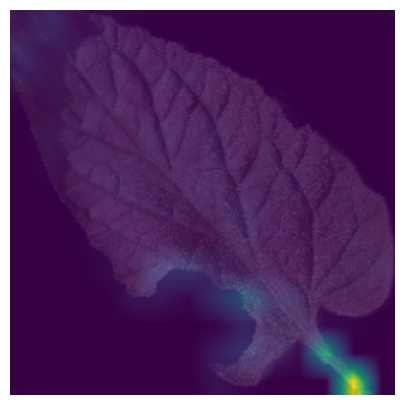

In [28]:
img = Image.open('/raid/ee-mariyam/maryam/ayush/PlantVillage_withoutbackground/val/Tomato___Late_blight/f8176522-163b-48ee-a1a2-ea94c782b4ad___RS_Late.B 6137_marked.JPG')
x = to_tensor(img).to(device)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)
y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
softmax = torch.nn.Softmax(dim=1)
probs = softmax(y)
predicted_class = torch.argmax(probs)
print(predicted_class)
# show_img(img)
# show_img(attn_map)
# show_img(cls_weight)
show_img(img_resized.cpu())
show_img2(img_resized.cpu(), cls_resized.cpu(), alpha=0.8)

tensor(2, device='cuda:0')


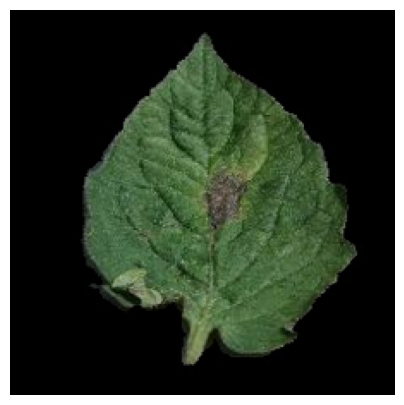

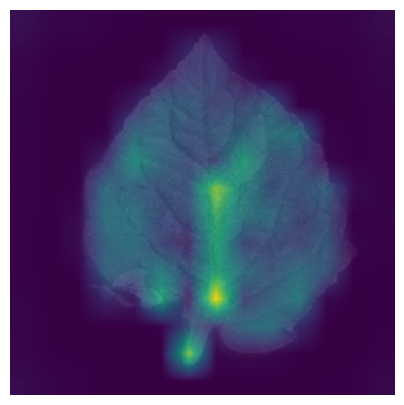

In [29]:
img = Image.open('/raid/ee-mariyam/maryam/ayush/PlantVillage_withoutbackground/val/Tomato___Late_blight/f33028e4-68df-4312-ba25-94d65f03efcf___RS_Late.B 5530_marked.JPG')
x = to_tensor(img).to(device)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)
y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
softmax = torch.nn.Softmax(dim=1)
probs = softmax(y)
predicted_class = torch.argmax(probs)
print(predicted_class)
# show_img(img)
# show_img(attn_map)
# show_img(cls_weight)
show_img(img_resized.cpu())
show_img2(img_resized.cpu(), cls_resized.cpu(), alpha=0.8)

tensor(9, device='cuda:0')


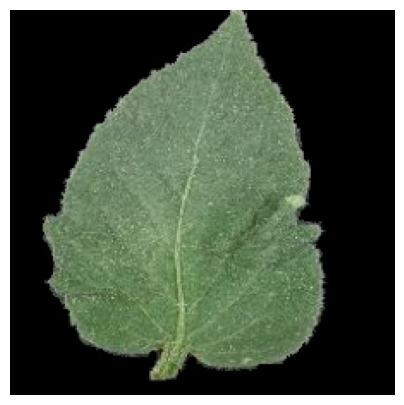

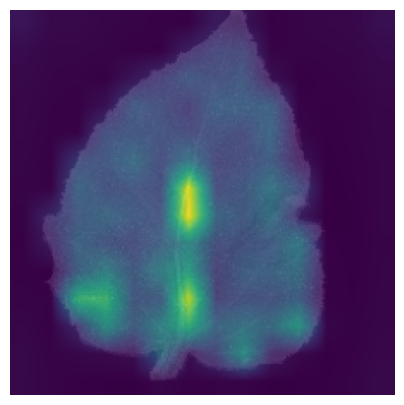

In [30]:
img = Image.open('/raid/ee-mariyam/maryam/ayush/PlantVillage_withoutbackground/train/Tomato___healthy/0b330273-890c-4995-af72-cba070fc0061___GH_HL Leaf 312_marked.JPG')
x = to_tensor(img).to(device)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)
y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
softmax = torch.nn.Softmax(dim=1)
probs = softmax(y)
predicted_class = torch.argmax(probs)
print(predicted_class)
# show_img(img)
# show_img(attn_map)
# show_img(cls_weight)
show_img(img_resized.cpu())
show_img2(img_resized.cpu(), cls_resized.cpu(), alpha=0.8)

In [26]:
print(model)

VisionTransformerDistilled(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): 